In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import plotly.express as px
from geopy.distance import great_circle
from sklearn.cluster import DBSCAN, KMeans
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
#DBSCAN es el algoritmo principal para el clustering basado en densidad/distancia geográfica. 
#KMeans se utiliza para dividir clusters grandes en subclusters más pequeños.
#geopy: Calcula la distancia entre dos puntos geográficos en metros utilizando la fórmula haversine.

In [2]:
# 1. CARGA Y LIMPIEZA DE DATOS
def cargar_y_limpiar_datos(path_csv: str) -> pd.DataFrame:
    df = pd.read_csv(path_csv)

    # Limpiar la columna CLIENTE
    pattern_digits = r"-?\d+$"
    df['CLIENTE'] = df['CLIENTE'].apply(lambda x: re.sub(pattern_digits, "", x))
    df['CLIENTE'] = df['CLIENTE'].apply(lambda x: re.sub(r"-[A-Za-z]$", "", x))

    # Crear columna SECTOR
    df.insert(2, 'SECTOR', df['RUTA'].str[:2])

    # Quitar filas con "S" en columnas específicas
    quitar_S_cols = ["TIENE CONVENIO", "TIENE BLOQUEO CORTE", "CLIENTE VIP", 
                     "TIENE RECLAMO COMERCIAL", "TIENE BLOQUEO DE RECONEXIóN"]
    df = df[~df[quitar_S_cols].apply(lambda row: row.str.contains('S').any(), axis=1)]
    
    return df

# 2. FILTRADO DE DATOS
def aplicar_filtros(df: pd.DataFrame) -> pd.DataFrame:
    condiciones = [
        ~df['F. CORTE CLIENTE'].str.contains('2500', na=False),
        ~df['DIRECCION'].str.contains('COSME|PINO|MORRO SOLAR', case=False, na=False),
        ~df['NOMBRE'].str.contains('MUNICIPALIDAD', case=False, na=False),
        df['DESC. SUCURSAL'] != 'Cañete',
        ~df['ANTIGUEDAD SIMULADA'].isin([0, 1, 2]),
        df['DISTRITO'] != 'EL AGUSTINO',
        ~df['TARIFA'].isin(['BT5E', 'BT6'])
    ]
    for condition in condiciones:
        df = df[condition]
    return df

# 3. CLUSTERING CON DBSCAN
def haversine_distance(coord1, coord2):
    return great_circle(coord1, coord2).kilometers

def aplicar_dbscan(df: pd.DataFrame, eps: float = 0.8, min_samples: int = 22) -> pd.DataFrame:
    coords = df[['COORDENADA DE LATITUD', 'COORDENADA DE LONGITUD']].to_numpy()
    db = DBSCAN(eps=eps, min_samples=min_samples, metric=haversine_distance).fit(coords)
    df['Cluster'] = db.labels_
    return df

# 4. SUBCLUSTERING CON KMEANS
def aplicar_subclustering(df: pd.DataFrame, max_points: int = 27) -> pd.DataFrame:
    for cluster_label in df['Cluster'].unique():
        if cluster_label == -1:
            continue
        cluster_points = df[df['Cluster'] == cluster_label]
        if len(cluster_points) > max_points:
            n_subclusters = int(np.ceil(len(cluster_points) / max_points))
            kmeans = KMeans(n_clusters=n_subclusters, random_state=0)
            subcluster_labels = kmeans.fit_predict(cluster_points[['COORDENADA DE LATITUD', 'COORDENADA DE LONGITUD']])
            for i, label in enumerate(subcluster_labels):
                df.loc[cluster_points.index[i], 'Cluster'] = f"{cluster_label}_{label}"
    return df

# 5. EXPORTACIÓN Y RESUMEN
def exportar_resultado(df: pd.DataFrame, output_csv: str) -> pd.DataFrame:
    columnas = ['CLIENTE', 'SECTOR', 'DISTRITO', 'DESC. SUCURSAL', 'DEUDA TOTAL', 
                'ANTIGUEDAD', 'DESC. EST. SUMINISTRO', 'CONSUMO KWH', 
                'COORDENADA DE LATITUD', 'COORDENADA DE LONGITUD', 'Cluster']
    df_filtrado = df[columnas]
    df_filtrado.to_csv(output_csv, index=False)
    return df_filtrado

In [3]:
# Ejecutar las funciones para generar el archivo resultado
df = cargar_y_limpiar_datos("todas.csv")
df = aplicar_filtros(df)
df = aplicar_dbscan(df)
df = aplicar_subclustering(df)
resultado = exportar_resultado(df, "Clusters.csv")

In [4]:
# Se genera un resumen estadístico por cluster, para atender los más críticos:
cluster_summary = resultado.groupby("Cluster").agg(
    total_clientes=("CLIENTE", "count"),
    deuda_total_soles=("DEUDA TOTAL", "sum"),
    consumo_promedio_kwh=("CONSUMO KWH", "mean"),
    antiguedad_promedio=("ANTIGUEDAD", "mean")
).reset_index()
cluster_summary = cluster_summary.sort_values(by="deuda_total_soles", ascending=False).reset_index(drop=True)

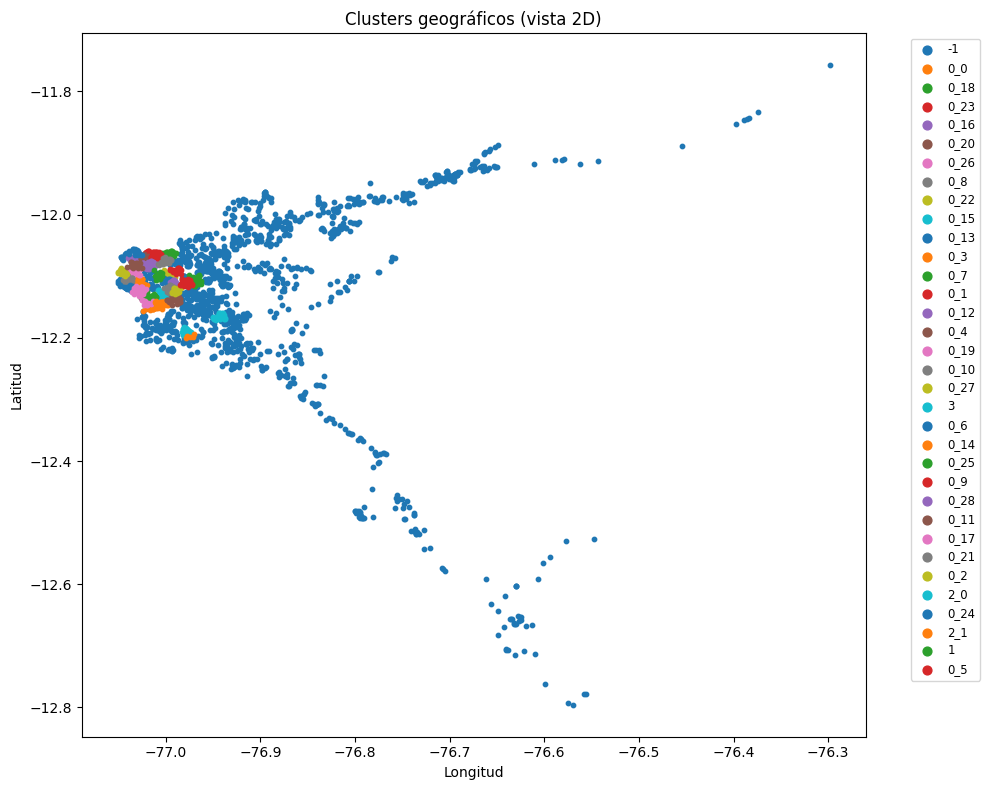

In [7]:
# Gráfico 2D simple con matplotlib
def visualizar_clusters_matplotlib(df):
    plt.figure(figsize=(10, 8))
    for cluster in df['Cluster'].unique():
        puntos = df[df['Cluster'] == cluster]
        plt.scatter(puntos['COORDENADA DE LONGITUD'], puntos['COORDENADA DE LATITUD'], label=str(cluster), s=10)

    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.title("Clusters geográficos (vista 2D)")
    plt.legend(markerscale=2, fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

visualizar_clusters_matplotlib(resultado)

In [6]:
# Aseguramos que las etiquetas de cluster sean cadenas para colorización
resultado['Cluster'] = resultado['Cluster'].astype(str)

# Creamos el mapa interactivo con Plotly
fig = px.scatter_mapbox(
    resultado,
    lat="COORDENADA DE LATITUD",
    lon="COORDENADA DE LONGITUD",
    color="Cluster",
    hover_name="CLIENTE",
    hover_data=["DISTRITO", "DESC. SUCURSAL", "DEUDA TOTAL", "ANTIGUEDAD", "CONSUMO KWH"],
    zoom=10,
    height=700,
    size_max=10
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0, "t":30, "l":0, "b":0}, title_text="Mapa de Clusters por coordenadas")
fig.show()